In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt

Pre processing and extracting feature


In [11]:
root_dirs = {
    'Train': r'C:\ML2 Final\raw\Train',
    'Test': r'C:\ML2 Final\raw\Test',
    'Validation': r'C:\ML2 Final\raw\Validation'
}

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_dataset(root_dir):
    images = []
    labels = []
    class_names = os.listdir(root_dir)
    for label in class_names:
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpg'):
                    file_path = os.path.join(class_dir, file_name)
                    image = Image.open(file_path).convert('RGB')
                    image = transform(image)
                    images.append(image)
                    labels.append(class_names.index(label))
    return torch.stack(images), np.array(labels), class_names

train_images, train_labels, class_names = load_dataset(root_dirs['Train'])
test_images, test_labels, class_names = load_dataset(root_dirs['Test'])
val_images, val_labels, class_names = load_dataset(root_dirs['Validation'])

model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  
model.eval()

def extract_features(images):
    with torch.no_grad():
        features = model(images).squeeze().numpy()
    return features

train_features = extract_features(train_images)
test_features = extract_features(test_images)
val_features = extract_features(val_images)


Feature extraction


SVM model

In [12]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(train_features, train_labels)

best_params = grid.best_params_
best_score = grid.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-validation Accuracy: {best_score}')

test_predictions = grid.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy with best model: {test_accuracy}')

val_predictions = grid.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy with best model: {val_accuracy}')

train_predictions = grid.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f'Train Accuracy: {train_accuracy}')

joblib.dump(grid.best_estimator_, 'svm_classifier_best1.pkl')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, 

['svm_classifier_best1.pkl']

Classification report

In [13]:
print("Classification Report for Test Set:\n", classification_report(test_labels, test_predictions, target_names=class_names))


Classification Report for Test Set:
               precision    recall  f1-score   support

     Healthy       0.89      0.96      0.92        50
     Powdery       1.00      0.90      0.95        50
        Rust       0.94      0.96      0.95        50

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150



test predict picture

Predicted Class: Rust


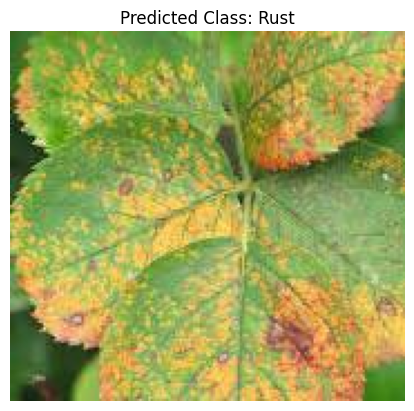

In [15]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

def extract_features_from_image(image_tensor, model):
    with torch.no_grad():
        features = model(image_tensor).squeeze().numpy()
    return features

svm_classifier = joblib.load('svm_classifier_best.pkl')

image_path = r'C:\ML2 Final\download (4).jpg'
image_tensor = preprocess_image(image_path)
image_features = extract_features_from_image(image_tensor, model)
image_features = image_features.reshape(1, -1)

predicted_class = svm_classifier.predict(image_features)
class_idx = {v: k for k, v in train_dataset.class_to_idx.items()}
predicted_class_name = class_idx[predicted_class[0]]

print(f'Predicted Class: {predicted_class_name}')

def display_image_with_prediction(image_path, prediction):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted Class: {prediction}')
    plt.axis('off')
    plt.show()

display_image_with_prediction(image_path, predicted_class_name)

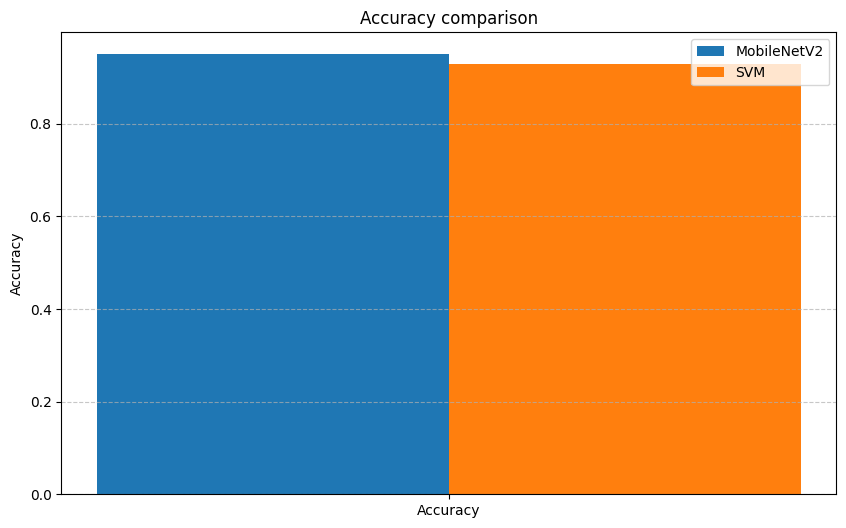

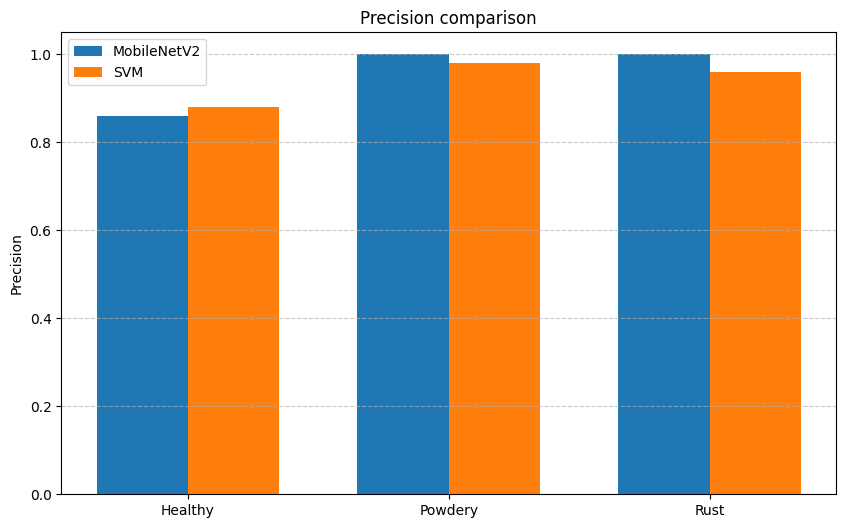

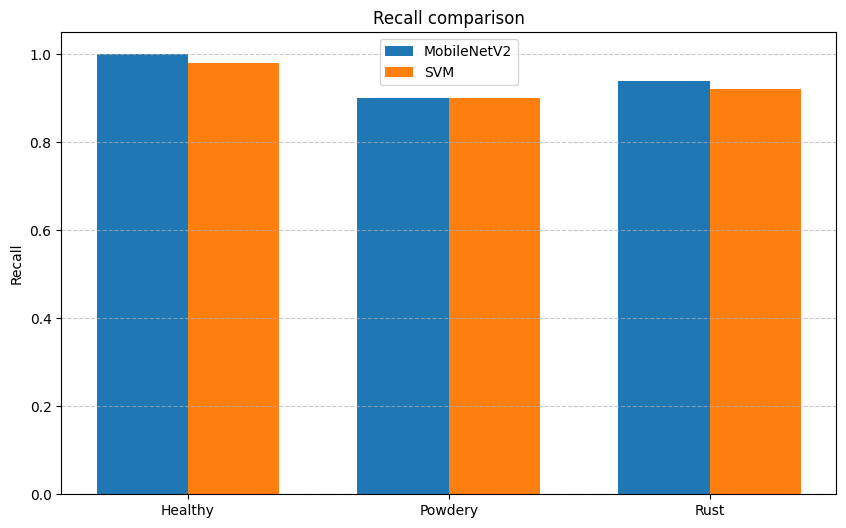

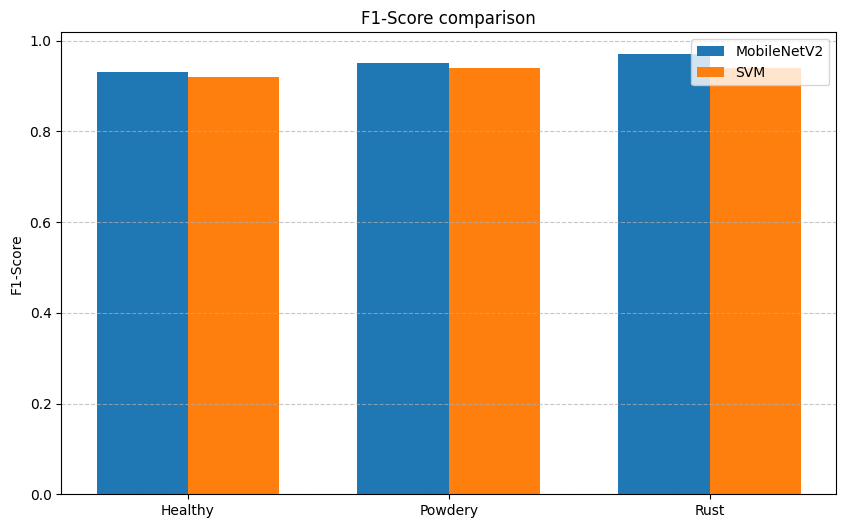

In [1]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy']
categories = ['Healthy', 'Powdery', 'Rust']
precision_mobilenet = [0.86, 1.00, 1.00]
recall_mobilenet = [1.00, 0.90, 0.94]
f1_mobilenet = [0.93, 0.95, 0.97]

precision_svm = [0.88, 0.98, 0.96]
recall_svm = [0.98, 0.90, 0.92]
f1_svm = [0.92, 0.94, 0.94]

accuracy_mobilenet = [0.95]
accuracy_svm = [0.93]

x = np.arange(len(categories))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
x_acc = np.arange(len(metrics))
ax.bar(x_acc - width/2, accuracy_mobilenet, width, label='MobileNetV2')
ax.bar(x_acc + width/2, accuracy_svm, width, label='SVM')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy comparison')
ax.set_xticks(x_acc)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, precision_mobilenet, width, label='MobileNetV2')
ax.bar(x + width/2, precision_svm, width, label='SVM')
ax.set_ylabel('Precision')
ax.set_title('Precision comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, recall_mobilenet, width, label='MobileNetV2')
ax.bar(x + width/2, recall_svm, width, label='SVM')
ax.set_ylabel('Recall')
ax.set_title('Recall comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, f1_mobilenet, width, label='MobileNetV2')
ax.bar(x + width/2, f1_svm, width, label='SVM')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
